# REDUCE Workshop | AI-Driven Image Recognition Techniques
## **Deep Learning Techniques for Image Recognition**

### May 6 & 7, 2025 | University of Barcelona, Spain

### Speakers:
- [Catarina Silva](https://catarinasilva.weebly.com), University of Coimbra (CFE), Portugal
- [Ricardo Cardoso Pereira](https://ricardodcpereira.com/), University of Coimbra (CISUC), Portugal
- [Nina del Rio Ares](https://www.iim.csic.es/en/about-iim/staff/nina-del-rio), Institute of Marine Research (IIM-CSIC), Spain

**This notebook showcases how to fine-tune a pre-trained deep-learning model and use it for inference purposes.**

**The used model is a convolutional network with the EfficientNetV2-S architecture from [EfficientNetV2: Smaller Models and Faster Training](https://arxiv.org/abs/2104.00298).**

The input images have been split into train, validation, and test sets, and they are available in the *images* folder.

We are considering 3 labels: **bottlenose_dolphin**, **loggerhead_turtle**, **scalloped_hammerhead**.

<u>Before executing the notebook</u>, set the **TRAIN_MODEL** boolean flag appropriately:
- If set to **True**, the pre-trained model is fine-tuned from scratch for our classification problem.
- If set to **False**, a previously fine-tuned model for our classification problem is downloaded and used.

In [2]:
TRAIN_MODEL = False

In [3]:
IMAGES_DIR = "images"

## Train & Fine-Tune Model

In [4]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
from tempfile import TemporaryDirectory
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

### Load the images from the train, validation, and test sets with the appropriate classes for PyTorch.

In [5]:
# Build the standard preprocessing pipeline that comes with EfficientNet-V2-S
# The transformations are described here:
#   https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_v2_s.html.
preprocess = EfficientNet_V2_S_Weights.DEFAULT.transforms()

# Read images from disk into PyTorch‐compatible datasets, one folder per set
image_datasets = {
  x: datasets.ImageFolder(
    os.path.join(IMAGES_DIR, x),
    preprocess  # Apply the EfficientNet transforms on-the-fly
  )
  for x in ["train", "val", "test"]
}

# Wrap each dataset in a DataLoader to produce shuffled mini-batches
dataloaders = {
  x: torch.utils.data.DataLoader(
    image_datasets[x],
    batch_size=8,
    shuffle=True,
    num_workers=2
  )
  for x in ["train", "val", "test"]
}

# Record the number of samples in each set
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val", "test"]}

# Capture the list of class labels inferred from the training folder structure
class_names = image_datasets["train"].classes

### Check if a GPU is available. If yes, use it for train and inference.

**Note:** Training the model in the CPU takes several hours and is not feasible.

In [6]:
device = torch.accelerator.current_accelerator().type \
          if torch.accelerator.is_available() else "cpu"
print(f"Train and inference will be performed using the {device} device.")

Train and inference will be performed using the cpu device.


### Define the training procedure for the model according to the standard steps required to train a neural network.

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()

  # Work in a temporary folder that will be deleted after the training ends
  with TemporaryDirectory() as temp_dir:
    # Path where the best-performing weights will be cached
    best_params_path = os.path.join(temp_dir, "best_params.pt")
    torch.save(model.state_dict(), best_params_path)
    best_acc_val = 0.0  # Highest validation accuracy seen so far
    best_acc_train = 0.0  # Highest training accuracy seen so far
    last_acc_train = 0.0  # Training accuracy for the most-recent epoch

    # Epoch loop
    for epoch in range(1, num_epochs + 1):
      print(f"Epoch {epoch} / {num_epochs}")
      print("-" * 20)

      # Phase loop: training vs. validation
      for phase in ["train", "val"]:
        # Switch model to the correct mode
        model.train() if phase == "train" else model.eval()

        running_loss = 0.0  # Cumulative loss for the phase
        running_corrects = 0  # Number of correct predictions

        # Mini-batch loop
        for inputs, labels in dataloaders[phase]:
          # Move data to the chosen device (CPU/GPU)
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()  # Reset gradients

          # Forward pass (and backward & step if training)
          with torch.set_grad_enabled(phase == "train"):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            if phase == "train":
              loss.backward()  # Compute gradients
              optimizer.step()  # Update weights

          # Accumulate metrics for the epoch statistics
          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)

        # End of phase: update LR, compute epoch metrics
        if phase == "train":
          scheduler.step()  # One LR-scheduler step per epoch

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(
          f"{'Validation' if phase == 'val' else 'Train'} --> "
          f"Loss: {epoch_loss:.4f} & Accuracy: {epoch_acc:.4f}"
        )

        # Track best model so far
        if phase == "train":
          last_acc_train = epoch_acc
        else:  # phase == "val"
          # Save weights if validation improves, or ties but with better train accuracy
          better_val = epoch_acc > best_acc_val
          tie_but_better_train = epoch_acc == best_acc_val and last_acc_train > best_acc_train
          if better_val or tie_but_better_train:
            best_acc_val = epoch_acc
            best_acc_train = last_acc_train
            torch.save(model.state_dict(), best_params_path)

      print()

    # Training finished: report time and metrics
    time_elapsed = time.time() - since
    print(f"Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best Validation Accuracy: {best_acc_val:.4f}")
    print(f"Best Train Accuracy: {best_acc_train:.4f}")

    # Load the best-performing parameters before returning
    model.load_state_dict(torch.load(best_params_path, weights_only=True))

  return model

### Train the model and save the parameters of the best epoch to be used later.

**Note:** The model is only trained if the user sets the **TRAIN_MODEL** boolean flag to **True**.

In [8]:
# Run this block only if training is enabled
if TRAIN_MODEL:
  # Load the EfficientNet-V2-S model with ImageNet weights
  model = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)

  # Replace the classification head to fit our problem
  num_features = model.classifier[1].in_features
  model.classifier[1] = nn.Linear(num_features, len(class_names))  # New output layer
  model = model.to(device)  # Move model to CPU or GPU

  # Define loss function, optimizer, and LR scheduler
  criterion = nn.CrossEntropyLoss()  # Multi-class loss
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Use SGD optimizer
  lr_decay_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)  # Drop LR by 10 times every 7 epochs

  # Train the network
  model_ft = train_model(
    model,
    criterion,
    optimizer,
    lr_decay_scheduler,
    num_epochs=25
  )

  # Save the best-performing weights to disk for later use
  best_model_params_path = os.path.join(".", "model_params.pt")
  torch.save(model_ft.state_dict(), best_model_params_path)

## Load Fine-Tuned Model

### Load the pre-trained fine-tuned model parameters.

**Note:** The model parameters (i.e., *model_params.pt* file) are only imported if the model was not trained from scratch in this execution.

In [9]:
%%capture
# Run this block only if training is disabled
if not TRAIN_MODEL:
  # Build the network architecture exactly as during training
  model_ft = efficientnet_v2_s()
  num_features = model_ft.classifier[1].in_features
  model_ft.classifier[1] = nn.Linear(num_features, len(class_names))

  # Restore the best weights saved earlier
  model_ft.load_state_dict(
    torch.load(
      "model_params.pt",
      weights_only=True,  # Load only parameter tensors
      map_location=torch.device(device)  # Map tensors to CPU or GPU
    )
  )

  # Put the network in inference mode (disable normalization and dropout layers)
  model_ft.eval()
  model_ft = model_ft.to(device)

## Model Inference

### Evaluate the model on the test set using the accuracy metric.

In [10]:
all_preds = []
all_labels = []

# Inference on the test set (no gradient calculations)
with torch.no_grad():
  for inputs, labels in dataloaders["test"]:  # Iterate over test batches
    inputs = inputs.to(device)  # Move data to the correct device (CPU/GPU)
    outputs = model_ft(inputs)  # Forward pass
    _, predicted = torch.max(outputs, 1)  # Class with highest logit
    all_preds.extend(predicted.cpu().numpy())  # Accumulate predictions
    all_labels.extend(labels.cpu().numpy())  # Accumulate ground truths

print(f"Model accuracy on the test set: {accuracy_score(all_labels, all_preds) * 100:.2f}%")

Model accuracy on the test set: 97.37%


### Visualize the model predictions for the first batch of the test set.

In [11]:
def visualize(model):
  with torch.no_grad():
    # Grab the first mini-batch from the test set
    inputs, labels = next(iter(dataloaders["test"]))
    inputs = inputs.to(device)
    num_images = len(labels)

    # Run the model to obtain predictions for the batch
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    # Plot each image with its predicted label
    for n in range(inputs.size(0)):
      ax = plt.subplot(num_images // 2, 2, n + 1)
      ax.axis("off")
      ax.set_title(f"{class_names[preds[n]]}")

      # Convert the tensor back to a displayable RGB image
      img = inputs.cpu().data[n].numpy().transpose((1, 2, 0))
      mean = np.array([0.485, 0.456, 0.406])  # ImageNet mean
      std  = np.array([0.229, 0.224, 0.225])  # ImageNet std
      img = std * img + mean  # Unnormalize
      img = np.clip(img, 0, 1)  # Clamp to valid range
      ax.imshow(img)  # Draw the image

    # Tidy up subplot spacing
    plt.tight_layout()

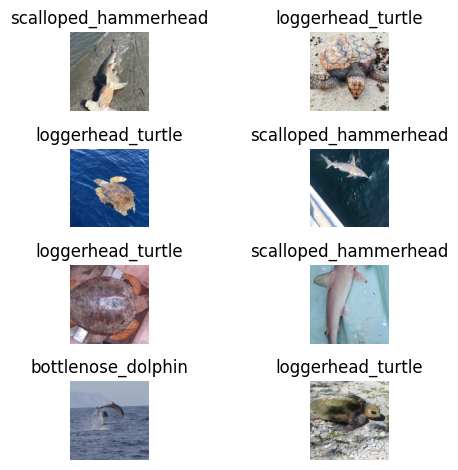

In [12]:
visualize(model_ft)

# **Exercises**

1. Adapt the provided example to fine-tune a Vision Transformer (ViT) with the architecture from [MaxViT: Multi-Axis Vision Transformer](https://arxiv.org/abs/2204.01697). The PyTorch pre-trained model for this architecture is available [here](https://pytorch.org/vision/main/models/generated/torchvision.models.maxvit_t.html).
2. Adapt the provided example to consider different labels, both in number and variety. The following labels are available: **blue_shark**, **bottlenose_dolphin**, **loggerhead_turtle**, **scalloped_hammerhead**, **shortfin_mako_shark**, **silky_shark**.

## Evaluating Model Performance

## Performance Metrics
The EfficientNet-V2-S model has already been trained. Now we evaluate its performance using common metrics like accuracy, precision, recall, F1-score, and the confusion matrix.

In [13]:
from sklearn.metrics import accuracy_score

# Calculate the accuracy of the model
accuracy = accuracy_score(all_labels, all_preds) * 100
print(f"Model accuracy on the test set: {accuracy:.2f}%")

Model accuracy on the test set: 97.37%


**Note:** Accuracy can be misleading when classes are imbalanced, as the model might favor the majority class.
Therefore, we can check whether the training set is balanced by counting the number of samples per class.

In [14]:
from collections import Counter

# Get the number of samples per class in the training dataset
class_counts = Counter(image_datasets["train"].targets)

# Print the number of samples for each class
for class_idx, class_name in enumerate(class_names):
    print(f"{class_name}: {class_counts[class_idx]}")

bottlenose_dolphin: 58
loggerhead_turtle: 61
scalloped_hammerhead: 45


**Confusion matrix** provides detailed insights by showing the number of correct and incorrect predictions per class. This helps identify specific classes the model may confuse with others.

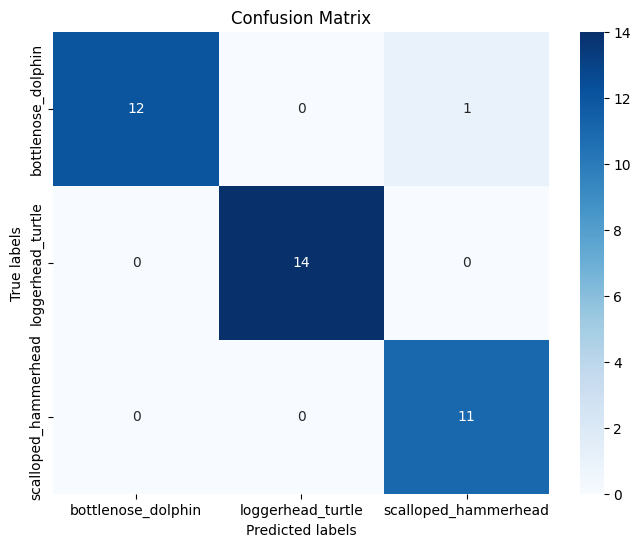

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

While accuracy gives an overall sense of model performance, it can be misleading when dealing with imbalanced datasets.
To gain deeper insights, we compute:
* Precision: How many of the predicted positives were actually correct?
* Recall (Sensitivity): How many of the actual positives did the model correctly identify?
* F1-Score: The harmonic mean of precision and recall - a balanced metric useful when both false positives and false negatives matter.

These metrics are computed per class and help us understand the model's strengths and weaknesses in a more granular way.

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate Precision, Recall, and F1-Score for each class
precision = precision_score(all_labels, all_preds, average=None)  # 'average=None' returns precision for each class
recall = recall_score(all_labels, all_preds, average=None)  # 'average=None' returns recall for each class
f1 = f1_score(all_labels, all_preds, average=None)  # 'average=None' returns F1 for each class

# Print precision, recall, and F1-score for each class
for i, class_name in enumerate(class_names):
    print(f"Class {class_name}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-Score: {f1[i]:.4f}")
    print()

# micro/macro averages:
precision_avg = precision_score(all_labels, all_preds, average='macro')
recall_avg = recall_score(all_labels, all_preds, average='macro')
f1_avg = f1_score(all_labels, all_preds, average='macro')

print(f"Macro Precision: {precision_avg:.4f}")
print(f"Macro Recall: {recall_avg:.4f}")
print(f"Macro F1-Score: {f1_avg:.4f}")

Class bottlenose_dolphin:
  Precision: 1.0000
  Recall: 0.9231
  F1-Score: 0.9600

Class loggerhead_turtle:
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000

Class scalloped_hammerhead:
  Precision: 0.9167
  Recall: 1.0000
  F1-Score: 0.9565

Macro Precision: 0.9722
Macro Recall: 0.9744
Macro F1-Score: 0.9722


## Data Augmentation

This script demonstrates an example of data augmentation for image classification tasks. It selects a random image from the training dataset, applies a series of visual transformations (like horizontal flipping, rotation, and color jitter), saves the augmented version, and then displays the original and augmented images side by side using *matplotlib*.

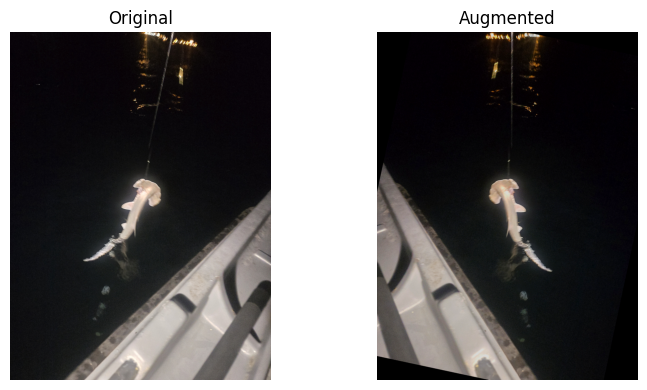

In [17]:
import random
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import glob
import os

def augment_and_show_example(train_dir):
  """
  Applies data augmentation to a random image and displays the original
  and augmented images side by side.

  Args:
      train_dir (str): Path to the training directory containing class subfolders.
  """
  # Define custom augmentation transformations
  augmentation = transforms.Compose([
      transforms.RandomHorizontalFlip(p=1.0),
      transforms.RandomRotation(degrees=30),
      transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
  ])

  # Randomly select a class folder
  classes = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
  selected_class = random.choice(classes)
  class_path = os.path.join(train_dir, selected_class)

  # Randomly select an image from the chosen class
  images = glob.glob(os.path.join(class_path, "*.jpg"))
  original_path = random.choice(images)

  # Load the image and apply augmentation
  with Image.open(original_path) as img:
    img = img.convert("RGB")
    augmented_img = augmentation(img)

    # Save the augmented image with a new name
    base_name = os.path.splitext(os.path.basename(original_path))[0]
    augmented_path = os.path.join(class_path, f"{base_name}_aug.jpg")
    augmented_img.save(augmented_path)

    # Display original and augmented images side by side
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(img)
    axes[0].set_title("Original")
    axes[0].axis("off")

    axes[1].imshow(augmented_img)
    axes[1].set_title("Augmented")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

# Run the function to see an example
augment_and_show_example(os.path.join(IMAGES_DIR, "train"))

In [18]:
import os
from torchvision import transforms
from PIL import Image
import glob

def augment_train_images(train_dir):
    """
    Duplicates the training dataset by applying custom data augmentations.

    Args:
        train_dir (str): Path to the training directory with subdirectories per class.
    """
    # Define data augmentation transforms
    augmentations = transforms.Compose([
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.RandomRotation(degrees=25),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    ])

    print("Augmenting images...\n")

    # Loop through each class folder
    for class_dir in os.listdir(train_dir):
        full_class_path = os.path.join(train_dir, class_dir)
        if not os.path.isdir(full_class_path):
            continue

        # Count original images
        original_images = glob.glob(os.path.join(full_class_path, "*.jpg"))
        print(f"Class '{class_dir}' - Original images: {len(original_images)}")

        for img_path in original_images:
            with Image.open(img_path) as img:
                img = img.convert("RGB")  # Ensure RGB format
                augmented_img = augmentations(img)

                # Save with new name
                base_name = os.path.basename(img_path)
                name_no_ext, ext = os.path.splitext(base_name)
                augmented_name = f"{name_no_ext}_aug{ext}"
                augmented_img.save(os.path.join(full_class_path, augmented_name))

        # Count total images after augmentation
        total_images = glob.glob(os.path.join(full_class_path, "*.jpg"))
        print(f"Class '{class_dir}' - Total images after augmentation: {len(total_images)}\n")

# Run data augmentation on training set (after original training has been completed)
train_dir = os.path.join(IMAGES_DIR, "train")
augment_train_images(train_dir)

Augmenting images...

Class 'scalloped_hammerhead' - Original images: 46
Class 'scalloped_hammerhead' - Total images after augmentation: 91

Class 'bottlenose_dolphin' - Original images: 58
Class 'bottlenose_dolphin' - Total images after augmentation: 116

Class 'loggerhead_turtle' - Original images: 61
Class 'loggerhead_turtle' - Total images after augmentation: 122



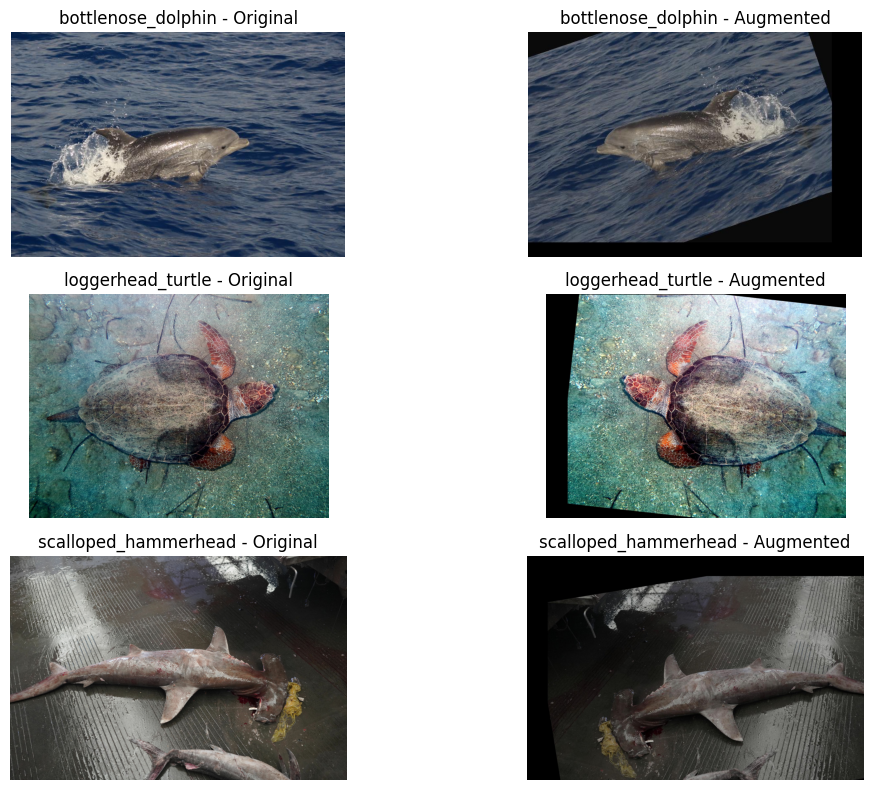

In [19]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

def show_augmented_examples(train_dir, class_names):
    """
    Display 3 examples of original images alongside their augmented versions (one per class).
    """
    plt.figure(figsize=(12, 8))
    shown = 0

    for idx, class_name in enumerate(class_names):
        class_path = os.path.join(train_dir, class_name)
        images = [img for img in os.listdir(class_path) if img.endswith('.jpg') and '_aug' not in img]

        if not images:
            continue

        # Select a random image from this class
        original_name = random.choice(images)
        base_name, ext = os.path.splitext(original_name)
        augmented_name = f"{base_name}_aug{ext}"

        original_path = os.path.join(class_path, original_name)
        augmented_path = os.path.join(class_path, augmented_name)

        # Skip if augmented version doesn't exist
        if not os.path.exists(augmented_path):
            continue

        # Load the original and augmented images
        original_img = Image.open(original_path)
        augmented_img = Image.open(augmented_path)

        # Show original image
        plt.subplot(len(class_names), 2, 2 * idx + 1)
        plt.imshow(original_img)
        plt.title(f"{class_name} - Original")
        plt.axis("off")

        # Show augmented image
        plt.subplot(len(class_names), 2, 2 * idx + 2)
        plt.imshow(augmented_img)
        plt.title(f"{class_name} - Augmented")
        plt.axis("off")

        shown += 1
        if shown == 3:
            break

    plt.tight_layout()
    plt.show()

# Call the function
show_augmented_examples(os.path.join(IMAGES_DIR, "train"), class_names)

## Exercises

1. (a) Modify the data augmentation strategy used for training:
```
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
])
```

   (b) Explore other transformation options and parameter ranges available in  [torchvision.transforms](https://pytorch.org/vision/0.9/transforms.html).

   (c) Retrain your model using the augmented dataset and evaluate it using the same classification metrics.

   (d) Compare the results with those obtained using the original (non-augmented) data and discuss the impact of data augmentation on model performance.

2. Once you've adapted the provided example to work with a different set of labels (Exercise 2 from the previous session), recompute the classification metrics on your test set. Report each metric and briefly interpret how well the model performs on your chosen label set.

## Cross-Validation: k-fold

This script performs a 3-fold cross-validation on an image classification task using a pretrained EfficientNet-V2-S backbone.

**Note:** Don't worry if this takes a while to run. Cross-validation with deep models and multiple epochs can be time-consuming. Just be patient and let each fold complete

In [20]:
from sklearn.model_selection import KFold
from torchvision import datasets, transforms
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
from torch.utils.data import Subset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import numpy as np
import os

# Configuration
k = 3                     # Number of folds for cross-validation
num_epochs = 3            # Number of full passes over the dataset per fold
batch_size = 8            # Number of samples processed in each training step
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Standard preprocessing pipeline for EfficientNet-V2-S
preprocess = EfficientNet_V2_S_Weights.DEFAULT.transforms()

# Load training and validation folders as one combined dataset for K-Fold
train_dataset = datasets.ImageFolder(
    os.path.join(IMAGES_DIR, 'train'),
    transform=preprocess
)
val_dataset = datasets.ImageFolder(
    os.path.join(IMAGES_DIR, 'val'),
    transform=preprocess
)
# Concatenate train + val into a single dataset
full_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])

# Prepare K-Fold splitter
kf = KFold(n_splits=k, shuffle=True, random_state=42)
fold_accuracies = []

print(f"\n Starting {k}-Fold Cross-Validation...\n")

# Loop over each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(full_dataset)):
    print(f"--- Fold {fold + 1}/{k} ---")

    # Create subset for this fold
    train_subset = Subset(full_dataset, train_idx)
    val_subset   = Subset(full_dataset, val_idx)

    # DataLoaders for training and validation
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True,  num_workers=2)
    val_loader   = DataLoader(val_subset,   batch_size=batch_size, shuffle=False, num_workers=2)

    # Initialize a fresh EfficientNet-V2-S model with pretrained weights
    model = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)
    # Freeze feature extractor layers to train only the classifier head
    for param in model.features.parameters():
        param.requires_grad = False

    # Replace the final classifier layer to match our number of classes
    num_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_features, len(class_names))
    model = model.to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # Training loop for the current fold
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)                 # Forward pass
            loss = criterion(outputs, labels)      # Compute loss
            loss.backward()                        # Backward pass
            optimizer.step()                       # Update weights

            # Track running statistics
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            correct_preds += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_subset)
        epoch_acc  = correct_preds.double() / len(train_subset)
        print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f}")

    # Validation for the current fold
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute and record the fold accuracy
    acc = accuracy_score(all_labels, all_preds)
    fold_accuracies.append(acc)
    print(f"Fold {fold + 1} Accuracy: {acc * 100:.2f}%\n")

# Compute and print the mean accuracy across all folds
mean_acc = np.mean(fold_accuracies)
print(f"Final Mean Accuracy across {k} folds: {mean_acc * 100:.2f}%")


 Starting 3-Fold Cross-Validation...

--- Fold 1/3 ---


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 168MB/s]


Epoch 1/3 - Loss: 0.9508 - Acc: 0.6033
Epoch 2/3 - Loss: 0.6447 - Acc: 0.8595
Epoch 3/3 - Loss: 0.5248 - Acc: 0.8678
Fold 1 Accuracy: 94.21%

--- Fold 2/3 ---
Epoch 1/3 - Loss: 0.9740 - Acc: 0.5826
Epoch 2/3 - Loss: 0.6813 - Acc: 0.8223
Epoch 3/3 - Loss: 0.5432 - Acc: 0.9008
Fold 2 Accuracy: 93.39%

--- Fold 3/3 ---
Epoch 1/3 - Loss: 0.9634 - Acc: 0.6281
Epoch 2/3 - Loss: 0.6667 - Acc: 0.8388
Epoch 3/3 - Loss: 0.5233 - Acc: 0.8967
Fold 3 Accuracy: 91.74%

Final Mean Accuracy across 3 folds: 93.11%
